## Requirements

In [2]:
! pip install yfinance
! pip install tensorflow

In [3]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

## Metrics

SMAPE

In [4]:
import numpy as np

def calculate_smape(actual, predicted):

    numerator = np.abs(predicted - actual)
    denominator = (np.abs(predicted) + np.abs(actual)) / 2

    smape = np.mean(numerator / denominator) * 100

    return smape

MAPE

In [5]:
import numpy as np

def calculate_mape(actual, predicted):

    actual = np.array(actual)
    predicted = np.array(predicted)

    absolute_percentage_errors = np.abs((actual - predicted) / actual)
    mape = np.mean(absolute_percentage_errors) * 100

    return mape

RSME

In [6]:
def calculate_rmse(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)

    squared_errors = (predicted - actual) ** 2
    mean_squared_error = np.mean(squared_errors)
    rmse = np.sqrt(mean_squared_error)

    return rmse

## Implementation

In [7]:
def download_stock_data(ticker, start_date, end_date, interval_time = '1h'):
    return yf.download(ticker, start=start_date, end=end_date, interval=interval_time)

def min_max_scaling(x):
    return (x - x.min()) / (x.max() - x.min())

### Data Preprocessing

In [8]:
def preprocess_data(data):
    print(data['Close'].max(),data['High'].values[0])
    data = data.apply(min_max_scaling)
    print(data['Close'].max(),data['High'].values[0])

    look_back = 60
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[['Open', 'High', 'Low', 'Close', 'Volume']].values[i:i + look_back])
        y.append(data['Close'].values[i + look_back])
    X = np.array(X)
    y = np.array(y)

    return X, y

In [9]:
apple_ticker = 'AAPL'
bitcoin_ticker = "BTC-USD"
msft_ticker = "MSFT"
ticker = apple_ticker

start_date = '2022-04-12'
end_date = '2023-04-01'
data = download_stock_data(ticker, start_date, end_date)
X_train, y_train = preprocess_data(data)

[*********************100%%**********************]  1 of 1 completed
175.6649932861328 169.8699951171875
1.0 0.8773677049955038


In [10]:
## for Microsoft:
# start_date = '2023-04-02'
# end_date = '2023-06-02'
# data = download_stock_data(msft_ticker, start_date, end_date)
# x_min = data.min()
# x_max = data.max()
# X_val, y_val = preprocess_data(data)
# print(X_val.shape)

In [11]:
## for Bitcoin:
# start_date = '2023-04-02'
# end_date = '2023-06-02'
# data = download_stock_data(bitcoin_ticker, start_date, end_date)
# x_min = data.min()
# x_max = data.max()
# X_val, y_val = preprocess_data(data)
# print(X_val.shape)

In [12]:
start_date = '2023-04-02'
end_date = '2023-06-02'
data = download_stock_data(apple_ticker, start_date, end_date)
x_min = data.min()
x_max = data.max()
X_val, y_val = preprocess_data(data)
print(X_val.shape)

[*********************100%%**********************]  1 of 1 completed
180.11000061035156 165.88999938964844
1.0 0.2803684517971555
(234, 60, 5)


In [13]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=60, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    learning_rate = 1e-5
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer , loss='mean_squared_error')
    return model

In [14]:
def inverse_min_max_scaling(x, min_val, max_val):
  return x * (max_val - min_val) + min_val

### Model

In [15]:
class MetricsPlotCallback(Callback):
    def __init__(self, epochs):
        super(MetricsPlotCallback, self).__init__()
        self.actual = inverse_min_max_scaling(y_val, x_min['Close'],x_max['Close'])
        self.epochs = epochs
        self.validation_data = X_val
        self.mape_scores = []
        self.smape_scores = []
        self.rmse_scores = []
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        predicted_values = self.model.predict(self.validation_data)
        predicted_values = inverse_min_max_scaling(predicted_values, x_min['Close'],x_max['Close'])
        mape = calculate_mape(self.actual, predicted_values)
        smape = calculate_smape(self.actual, predicted_values)
        rmse = calculate_rmse(self.actual, predicted_values)

        self.mape_scores.append(mape)
        self.smape_scores.append(smape)
        self.rmse_scores.append(rmse)
        self.losses.append(logs['loss'])

        print(f'Epoch {epoch+1}/{self.epochs} - MAPE: {mape:.2f}, SMAPE: {smape:.2f}, RMSE: {rmse:.2f}')


def train_lstm_model(X_train, y_train, epochs=10, batch_size=32):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[metrics_callback])
    return model

epochs = 4
metrics_callback = MetricsPlotCallback(epochs)
model = train_lstm_model(X_train, y_train, epochs= epochs)

Epoch 1/4
8/8 [==============================] - 3s 39ms/step
Epoch 1/4 - MAPE: 6.16, SMAPE: 6.39, RMSE: 11.43
52/52 [==============================] - 16s 214ms/step - loss: 0.2806
Epoch 2/4
8/8 [==============================] - 0s 40ms/step
Epoch 2/4 - MAPE: 5.31, SMAPE: 5.49, RMSE: 10.11
52/52 [==============================] - 10s 182ms/step - loss: 0.2106
Epoch 3/4
8/8 [==============================] - 0s 55ms/step
Epoch 3/4 - MAPE: 4.48, SMAPE: 4.61, RMSE: 8.88
52/52 [==============================] - 10s 200ms/step - loss: 0.1518
Epoch 4/4
8/8 [==============================] - 0s 46ms/step
Epoch 4/4 - MAPE: 3.76, SMAPE: 3.86, RMSE: 7.73
52/52 [==============================] - 9s 179ms/step - loss: 0.1028


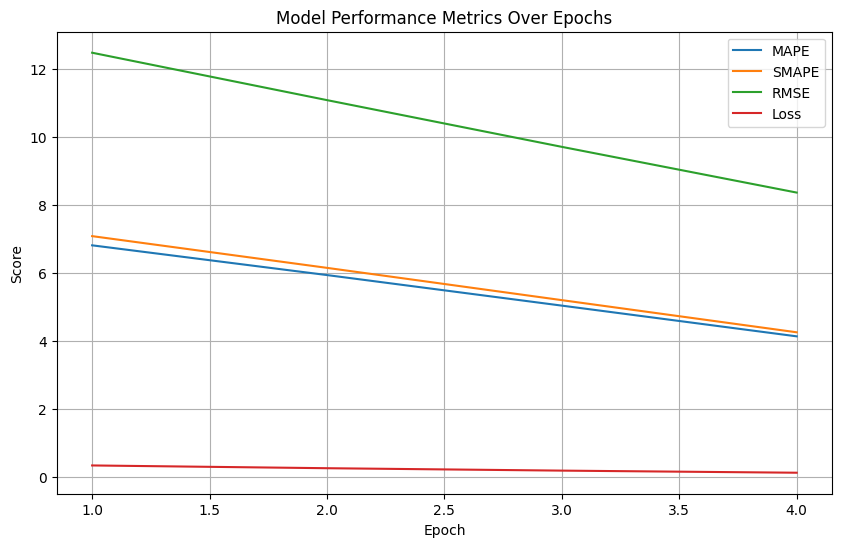

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), metrics_callback.mape_scores, label='MAPE')
plt.plot(range(1, epochs + 1), metrics_callback.smape_scores, label='SMAPE')
plt.plot(range(1, epochs + 1), metrics_callback.rmse_scores, label='RMSE')
plt.plot(range(1, epochs + 1), metrics_callback.losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Model Performance Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def predict_stock_price(model, X_new):
    X_new = X_new.reshape(1, X_new.shape[0], X_new.shape[1])
    predicted_price = model.predict(X_new)
    return predicted_price[0][0]

In [ ]:
ticker = 'AAPL'
start_date = '2023-05-02'
end_date = '2023-08-03'


data = download_stock_data(ticker, start_date, end_date)
x_min = data.min()
x_max = data.max()
data.shape

[*********************100%%**********************]  1 of 1 completed


(444, 6)

In [ ]:
X_new, y_new = preprocess_data(data)

196.49000549316406 170.35000610351562
1.0 0.14109682799494946


In [ ]:
predictions = []
for i in range(len(X_new)):
    prediction = predict_stock_price(model, X_new[i])
    predictions.append(prediction)

1/1 [==============================] - 0s 37ms/step


In [ ]:
predictions = np.asarray(predictions)
predictions_reversed = inverse_min_max_scaling(predictions, x_min['Close'],x_max['Close'])

In [ ]:
y_new = np.asarray(y_new)
y_new_rev = inverse_min_max_scaling(y_new, x_min['Close'],x_max['Close'])

In [ ]:
predictions_reversed[0]

168.47044

In [ ]:
for i in range(len(predictions_reversed)):
    date = data.index[i]
    predicted_price = predictions_reversed[i]
    print(f"Date: {date}, Predicted Price: {predicted_price:.2f}, Actual Price: {y_new_rev[i]}")

mape = calculate_mape(y_new_rev, predictions_reversed)
smape = calculate_smape(y_new_rev, predictions_reversed)
rmse = calculate_rmse(y_new_rev, predictions_reversed)


print(f'MAPE: {mape:.2f}, SMAPE: {smape:.2f}, RMSE: {rmse:.2f}')

Date: 2023-05-02 09:30:00-04:00, Predicted Price: 168.47, Actual Price: 171.3300018310547
Date: 2023-05-02 10:30:00-04:00, Predicted Price: 168.47, Actual Price: 171.9001007080078
Date: 2023-05-02 11:30:00-04:00, Predicted Price: 168.46, Actual Price: 172.55999755859375
Date: 2023-05-02 12:30:00-04:00, Predicted Price: 168.46, Actual Price: 171.8428955078125
Date: 2023-05-02 13:30:00-04:00, Predicted Price: 168.46, Actual Price: 172.27000427246094
Date: 2023-05-02 14:30:00-04:00, Predicted Price: 168.45, Actual Price: 172.17869567871094
Date: 2023-05-02 15:30:00-04:00, Predicted Price: 168.43, Actual Price: 171.8470001220703
Date: 2023-05-03 09:30:00-04:00, Predicted Price: 168.42, Actual Price: 171.81500244140625
Date: 2023-05-03 10:30:00-04:00, Predicted Price: 168.41, Actual Price: 171.81219482421875
Date: 2023-05-03 11:30:00-04:00, Predicted Price: 168.40, Actual Price: 172.1300048828125
Date: 2023-05-03 12:30:00-04:00, Predicted Price: 168.40, Actual Price: 172.41000366210938
Date

### save model

In [ ]:
model.save('apple_model.h5')

## Quantization

In [ ]:
! pip install tensorflow_model_optimization

In [ ]:
import tensorflow as tf
import tensorflow.lite as tflite
import tensorflow_model_optimization as tfmot

In [ ]:
model.layers[:2]

In [ ]:
annotated_layers = [
    tfmot.quantization.keras.quantize_annotate_layer(model.layers[0]),
    tfmot.quantization.keras.quantize_annotate_layer(model.layers[1])
]

In [ ]:
quantize_model = tf.keras.Sequential(annotated_layers + model.layers[2:])

In [ ]:
quantize_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quantize_model)

In [ ]:
converter.experimental_new_converter = True

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

In [ ]:
tflite_model = converter.convert()

Save quantized model to a file

In [ ]:
with open('apple_quantized_model.tflite', 'wb') as f:
    f.write(tflite_model)

## Quantized model

### Load the quantized model

using TensorFlow Lite Interpreter

In [ ]:
!pip install tensorflow_model_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 3.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow.lite as tflite
import tensorflow_model_optimization as tfmot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
%cd /content/drive/MyDrive/stock prediction

/content/drive/MyDrive/stock prediction


In [ ]:
model_path = 'apple_quantized_model.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

### Run inference

In [ ]:
def predict_stock_price_quantized(X_new):
    X_new = X_new.reshape(1, X_new.shape[0], X_new.shape[1])
    X_new = X_new.astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], X_new)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    return output_data[0][0]

In [ ]:
ticker = 'AAPL'
start_date = '2023-05-02'
end_date = '2023-08-03'

data = download_stock_data(ticker, start_date, end_date)
x_min = data.min()
x_max = data.max()
data.shape

[*********************100%%**********************]  1 of 1 completed


(444, 6)

In [ ]:
X_new, y_new = preprocess_data(data)

196.49000549316406 170.35000610351562
1.0 0.14109682799494946


In [ ]:
predictions = []
for i in range(len(X_new)):
    prediction = predict_stock_price_quantized(X_new[i])
    predictions.append(prediction)

In [ ]:
predictions = np.asarray(predictions)
predictions_reversed = inverse_min_max_scaling(predictions, x_min['Close'],x_max['Close'])

In [ ]:
y_new = np.asarray(y_new)
y_new_rev = inverse_min_max_scaling(y_new, x_min['Close'],x_max['Close'])

In [ ]:
for i in range(len(predictions_reversed)):
    date = data.index[i]
    predicted_price = predictions_reversed[i]
    print(f"Date: {date}, Predicted Price: {predicted_price:.2f}, Actual Price: {y_new_rev[i]}")

mape = calculate_mape(y_new_rev, predictions_reversed)
smape = calculate_smape(y_new_rev, predictions_reversed)
rmse = calculate_rmse(y_new_rev, predictions_reversed)


print(f'MAPE: {mape:.2f}, SMAPE: {smape:.2f}, RMSE: {rmse:.2f}')

Date: 2023-05-02 09:30:00-04:00, Predicted Price: 174.18, Actual Price: 171.3300018310547
Date: 2023-05-02 10:30:00-04:00, Predicted Price: 174.14, Actual Price: 171.9001007080078
Date: 2023-05-02 11:30:00-04:00, Predicted Price: 174.09, Actual Price: 172.55999755859375
Date: 2023-05-02 12:30:00-04:00, Predicted Price: 174.02, Actual Price: 171.8428955078125
Date: 2023-05-02 13:30:00-04:00, Predicted Price: 173.97, Actual Price: 172.27000427246094
Date: 2023-05-02 14:30:00-04:00, Predicted Price: 173.91, Actual Price: 172.17869567871094
Date: 2023-05-02 15:30:00-04:00, Predicted Price: 173.85, Actual Price: 171.8470001220703
Date: 2023-05-03 09:30:00-04:00, Predicted Price: 173.79, Actual Price: 171.81500244140625
Date: 2023-05-03 10:30:00-04:00, Predicted Price: 173.72, Actual Price: 171.81219482421875
Date: 2023-05-03 11:30:00-04:00, Predicted Price: 173.65, Actual Price: 172.1300048828125
Date: 2023-05-03 12:30:00-04:00, Predicted Price: 173.58, Actual Price: 172.41000366210938
Date

## Comparison between Models

### Requirements

In [ ]:
%cd /content/drive/MyDrive/stock prediction

/content/drive/MyDrive/stock prediction


In [ ]:
import tensorflow as tf
import tensorflow.lite as tflite
import tensorflow_model_optimization as tfmot
import os
import psutil
import time

### load plain model

In [ ]:
def predict_stock_price(X_new):
    X_new = X_new.reshape(1, X_new.shape[0], X_new.shape[1])
    predicted_price = plain_model.predict(X_new)
    return predicted_price[0][0]

In [ ]:
model_path = 'apple_model.h5'
plain_model = tf.keras.models.load_model(model_path)
plain_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            15840     
                                                                 
 lstm_1 (LSTM)               (None, 50)                22200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 38,091
Trainable params: 38,091
Non-trainable params: 0
_________________________________________________________________


### load Lite model model

In [ ]:
def predict_stock_price_quantized(X_new):
    X_new = X_new.reshape(1, X_new.shape[0], X_new.shape[1])
    X_new = X_new.astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], X_new)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    return output_data[0][0]

In [ ]:
model_path = 'apple_quantized_model.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_details

[{'name': 'serving_default_quantize_annotate_2_input:0',
  'index': 0,
  'shape': array([ 1, 60,  5], dtype=int32),
  'shape_signature': array([-1, 60,  5], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 48,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

### Number of Trainable Parameters

In [ ]:
interpreter.get_tensor_details()

[{'name': 'serving_default_quantize_annotate_2_input:0',
  'index': 0,
  'shape': array([ 1, 60,  5], dtype=int32),
  'shape_signature': array([-1, 60,  5], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'strided_slice_2',
  'index': 1,
  'shape': array([3], dtype=int32),
  'shape_signature': array([3], dtype=int32),
  'dtype': numpy.int32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'strided_slice_21',
  'index': 2,
  'shape': array([3], dtype=int32),
  'shape_signature': array([3], dtype=int32),
  'dtype': numpy.int32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': 

In [ ]:
full_model_trainable_params = plain_model.count_params()
tflite_model_trainable_params = 0
for tensor in interpreter.get_tensor_details():
    shape = tensor['shape']
    if len(shape) > 0:
        tflite_model_trainable_params += shape[-1]

In [ ]:
for tensor in interpreter.get_tensor_details():
    print(tensor['shape'])

[ 1 60  5]
[3]
[3]
[3]
[]
[2]
[2]
[]
[3]
[200]
[240]
[1]
[]
[]
[]
[1]
[1]
[ 1 50]
[3]
[]
[2]
[ 1 60]
[60  1  5]
[]
[]
[]
[]
[ 1 60]
[ 1 60]
[60  1  5]
[ 1  1 60]
[ 1  1 60]
[3]
[]
[2]
[ 1 50]
[]
[3]
[]
[]
[]
[]
[ 1 50]
[ 1 50]
[]
[ 1  1 60]
[ 1  1 50]
[ 1 50]
[1 1]


In [ ]:
print("Full Model Trainable Parameters:", full_model_trainable_params)
print("TFLite Model Trainable Parameters:", tflite_model_trainable_params)

Full Model Trainable Parameters: 38091
TFLite Model Trainable Parameters: 1148


### Number of Layers

In [ ]:
full_model_num_layers = len(plain_model.layers)

tflite_model_num_layers = len(interpreter.get_tensor_details())

In [ ]:
print("Full Model Number of Layers:", full_model_num_layers)
print("TFLite Model Number of Layers:", tflite_model_num_layers)

Full Model Number of Layers: 3
TFLite Model Number of Layers: 49


### Size

In [ ]:
full_model_size = os.path.getsize('apple_model.h5')
tflite_model_size = os.path.getsize('apple_quantized_model.tflite')

In [ ]:
print("Full Model Size (bytes):", full_model_size)
print("TFLite Model Size (bytes):", tflite_model_size)

Full Model Size (bytes): 499784
TFLite Model Size (bytes): 170536


### Memory Footprint

In [ ]:
model_path = 'apple_model.h5'
plain_model = tf.keras.models.load_model(model_path)

input_shape = plain_model.input_shape[1:]
sample_input = tf.random.uniform((1, *input_shape))

memory_before = psutil.virtual_memory().used

_ = plain_model.predict(sample_input)

memory_after = psutil.virtual_memory().used

memory_used_full_model = memory_after - memory_before
print("Memory used by Full Model:", memory_used_full_model, "bytes")

1/1 [==============================] - 3s 3s/step
Memory used by Full Model: 80056320 bytes


In [ ]:
import tensorflow as tf
import psutil

model_path = 'apple_quantized_model.tflite'
tflite_interpreter = tf.lite.Interpreter(model_path=model_path)
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
input_shape = input_details[0]['shape'][1:]  # Exclude batch dimension
sample_input = tf.random.uniform((1, *input_shape), dtype=input_details[0]['dtype'])

memory_before = psutil.virtual_memory().used

tflite_interpreter.set_tensor(input_details[0]['index'], sample_input)
tflite_interpreter.invoke()

memory_after = psutil.virtual_memory().used

memory_used_tflite_model = memory_after - memory_before
print("Memory used by TFLite Model:", memory_used_tflite_model, "bytes")

Memory used by TFLite Model: 0 bytes


### Inference Speed

#### Inference time on random data

In [ ]:
input_shape = plain_model.input_shape[1:]
sample_input = tf.random.uniform((1, *input_shape))

start_time = time.time()
_ = plain_model.predict(sample_input)
full_model_inference_time = time.time() - start_time

tflite_input_index = interpreter.get_input_details()[0]['index']
tflite_output_index = interpreter.get_output_details()[0]['index']

start_time = time.time()
interpreter.set_tensor(tflite_input_index, sample_input)
interpreter.invoke()
tflite_model_inference_time = time.time() - start_time

print("Full Model Inference Time:", full_model_inference_time)
print("TFLite Model Inference Time:", tflite_model_inference_time)

1/1 [==============================] - 0s 135ms/step
Full Model Inference Time: 0.2532010078430176
TFLite Model Inference Time: 0.010959625244140625


#### Inference time on test data

In [ ]:
ticker = 'AAPL'
start_date = '2023-05-02'
end_date = '2023-08-03'

data = download_stock_data(ticker, start_date, end_date)
x_min = data.min()
x_max = data.max()
data.shape

[*********************100%%**********************]  1 of 1 completed


(444, 6)

In [ ]:
X_new, y_new = preprocess_data(data)

196.49000549316406 170.35000610351562
1.0 0.14109682799494946


In [ ]:
start_time = time.time()
for i in range(len(X_new)):
    _ = predict_stock_price_quantized(X_new[i])
tflite_model_inference_time = time.time() - start_time

In [ ]:
start_time = time.time()
for i in range(len(X_new)):
    _ = predict_stock_price(X_new[i])
full_model_inference_time = time.time() - start_time

1/1 [==============================] - 0s 29ms/step


In [ ]:
print("Full Model Inference Time:", full_model_inference_time)
print("TFLite Model Inference Time:", tflite_model_inference_time)

Full Model Inference Time: 42.152159452438354
TFLite Model Inference Time: 4.159500360488892


### Metrics

In [ ]:
ticker = 'AAPL'
start_date = '2023-05-02'
end_date = '2023-08-03'

data = download_stock_data(ticker, start_date, end_date)
x_min = data.min()
x_max = data.max()
data.shape

[*********************100%%**********************]  1 of 1 completed


(444, 6)

In [ ]:
X_new, y_new = preprocess_data(data)

196.49000549316406 170.35000610351562
1.0 0.14109682799494946


In [ ]:
lite_predictions = []
for i in range(len(X_new)):
    prediction = predict_stock_price_quantized(X_new[i])
    lite_predictions.append(prediction)

predictions = np.asarray(lite_predictions)
predictions_reversed = inverse_min_max_scaling(predictions, x_min['Close'],x_max['Close'])

y_new = np.asarray(y_new)
y_new_rev = inverse_min_max_scaling(y_new, x_min['Close'],x_max['Close'])

for i in range(len(predictions_reversed)):
    date = data.index[i]
    predicted_price = predictions_reversed[i]
    print(f"Date: {date}, Predicted Price: {predicted_price:.2f}, Actual Price: {y_new_rev[i]}")

lite_mape = calculate_mape(y_new_rev, predictions_reversed)
lite_smape = calculate_smape(y_new_rev, predictions_reversed)
lite_rmse = calculate_rmse(y_new_rev, predictions_reversed)

Date: 2023-05-02 09:30:00-04:00, Predicted Price: 174.18, Actual Price: 171.3300018310547
Date: 2023-05-02 10:30:00-04:00, Predicted Price: 174.14, Actual Price: 171.9001007080078
Date: 2023-05-02 11:30:00-04:00, Predicted Price: 174.09, Actual Price: 172.55999755859375
Date: 2023-05-02 12:30:00-04:00, Predicted Price: 174.02, Actual Price: 171.8428955078125
Date: 2023-05-02 13:30:00-04:00, Predicted Price: 173.97, Actual Price: 172.27000427246094
Date: 2023-05-02 14:30:00-04:00, Predicted Price: 173.91, Actual Price: 172.17869567871094
Date: 2023-05-02 15:30:00-04:00, Predicted Price: 173.85, Actual Price: 171.8470001220703
Date: 2023-05-03 09:30:00-04:00, Predicted Price: 173.79, Actual Price: 171.81500244140625
Date: 2023-05-03 10:30:00-04:00, Predicted Price: 173.72, Actual Price: 171.81219482421875
Date: 2023-05-03 11:30:00-04:00, Predicted Price: 173.65, Actual Price: 172.1300048828125
Date: 2023-05-03 12:30:00-04:00, Predicted Price: 173.58, Actual Price: 172.41000366210938
Date

In [ ]:
plain_predictions = []
for i in range(len(X_new)):
    prediction = predict_stock_price(X_new[i])
    plain_predictions.append(prediction)

predictions = np.asarray(plain_predictions)
predictions_reversed = inverse_min_max_scaling(predictions, x_min['Close'],x_max['Close'])

y_new = np.asarray(y_new)
y_new_rev = inverse_min_max_scaling(y_new, x_min['Close'],x_max['Close'])

for i in range(len(predictions_reversed)):
    date = data.index[i]
    predicted_price = predictions_reversed[i]
    print(f"Date: {date}, Predicted Price: {predicted_price:.2f}, Actual Price: {y_new_rev[i]}")

full_mape = calculate_mape(y_new_rev, predictions_reversed)
full_smape = calculate_smape(y_new_rev, predictions_reversed)
full_rmse = calculate_rmse(y_new_rev, predictions_reversed)

1/1 [==============================] - 0s 33ms/step
Date: 2023-05-02 09:30:00-04:00, Predicted Price: 174.18, Actual Price: 171.3300018310547
Date: 2023-05-02 10:30:00-04:00, Predicted Price: 174.14, Actual Price: 171.9001007080078
Date: 2023-05-02 11:30:00-04:00, Predicted Price: 174.09, Actual Price: 172.55999755859375
Date: 2023-05-02 12:30:00-04:00, Predicted Price: 174.02, Actual Price: 171.8428955078125
Date: 2023-05-02 13:30:00-04:00, Predicted Price: 173.97, Actual Price: 172.27000427246094
Date: 2023-05-02 14:30:00-04:00, Predicted Price: 173.91, Actual Price: 172.17869567871094
Date: 2023-05-02 15:30:00-04:00, Predicted Price: 173.85, Actual Price: 171.8470001220703
Date: 2023-05-03 09:30:00-04:00, Predicted Price: 173.79, Actual Price: 171.81500244140625
Date: 2023-05-03 10:30:00-04:00, Predicted Price: 173.72, Actual Price: 171.81219482421875
Date: 2023-05-03 11:30:00-04:00, Predicted Price: 173.65, Actual Price: 172.1300048828125
Date: 2023-05-03 12:30:00-04:00, Predicted 

In [ ]:
for x, y in zip(plain_predictions, lite_predictions):
  if x != y:
    print(x, y)

0.27908367 0.27908364
0.27537504 0.27537507
0.26499063 0.2649906
0.26248 0.26247996
0.26134548 0.26134554
0.26018667 0.26018664
0.25831786 0.25831783
0.2575601 0.25756013
0.25216627 0.25216633
0.2533709 0.25337094
0.256265 0.25626504
0.26758242 0.26758245
0.27778575 0.27778578
0.2839696 0.28396964
0.29027066 0.29027063
0.29635617 0.29635614
0.3021827 0.30218273
0.307656 0.30765596
0.31264588 0.3126459
0.31679404 0.316794
0.3199814 0.31998137
0.32249793 0.3224979
0.32550985 0.3255098
0.32626802 0.326268
0.32660806 0.3266081
0.3261965 0.32619646
0.3249872 0.32498723
0.3231443 0.32314432
0.32044697 0.32044703
0.31289235 0.31289238
0.30848843 0.3084884
0.2873901 0.28739014
0.28177282 0.28177285
0.27153262 0.27153268
0.26128134 0.26128137
0.26091337 0.26091334
0.26105112 0.26105115
0.2618433 0.26184326
0.27068695 0.27068698
0.28034905 0.28034902
0.28550443 0.2855044
0.29094517 0.29094514
0.297832 0.29783204
0.30527928 0.30527934
0.31314278 0.31314275
0.32887065 0.3288706
0.3365069 0.3365068

In [ ]:
print(f'Full Model --- MAPE: {full_mape:.2f}, SMAPE: {full_smape:.2f}, RMSE: {full_rmse:.2f}')
print(f'Quantized Model --- MAPE: {lite_mape:.2f}, SMAPE: {lite_smape:.2f}, RMSE: {lite_rmse:.2f}')

Full Model --- MAPE: 1.14, SMAPE: 1.14, RMSE: 2.47
Quantized Model --- MAPE: 1.14, SMAPE: 1.14, RMSE: 2.47


## Alpaca Backtrader Integration

### Load TinyML model

In [ ]:
def predict_stock_price_quantized(X_new):
    X_new = X_new.reshape(1, X_new.shape[0], X_new.shape[1])
    X_new = X_new.astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], X_new)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    return output_data[0][0]

In [ ]:
model_path = 'apple_quantized_model.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

### Backtest

In [ ]:
! pip install backtrader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 6.2 MB/s eta 0:00:00


In [ ]:
!apt-get install -y build-essential libssl-dev libffi-dev python3-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libssl-dev is already the newest version (3.0.2-0ubuntu1.10).
python3-dev is already the newest version (3.10.6-1~22.04).
python3-dev set to manually installed.
The following NEW packages will be installed:
  libffi-dev
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 63.7 kB of archives.
After this operation, 336 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libffi-dev amd64 3.4.2-4 [63.7 kB]
Fetched 63.7 kB in 1s (68.6 kB/s)
Selecting previously unselected package libffi-dev:amd64.
(Reading database ... 120893 files and directories currently installed.)
Preparing to unpack .../libffi-dev_3.4.2-4_amd64.deb ...
Unpacking libffi-dev:amd64 (3.4.2-4) ...
Setting up libffi-dev:amd64 (3.4.2-4) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
import backtrader as bt
import pandas as pd

In [ ]:

# import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np

In [ ]:

import backtrader as bt
import numpy as np

In [ ]:
# Replace with your own Alpaca API credentials
API_KEY = 'PK440XDIDQ95UVSR5FFM'
API_SECRET = '8o3JzfrA4J88QnhjbPOFnBAxPLb86RXNK3XCa8n2'
PAPER_BASE_URL = 'https://paper-api.alpaca.markets'  # For paper trading

In [ ]:
def predict_stock_price_quantized(X_new):
    X_new = X_new.reshape(1, X_new.shape[0], X_new.shape[1])
    X_new = X_new.astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], X_new)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    return output_data[0][0]

In [ ]:
def predict_price_lstm(historical_data):
    return predict_stock_price_quantized(historical_data)

In [ ]:
def preprocess_data(data):
    print(data['Close'].max(),data['High'].values[0])
    data = data.apply(min_max_scaling)
    print(data['Close'].max(),data['High'].values[0])

    look_back = 60
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[['Open', 'High', 'Low', 'Close', 'Volume']].values[i:i + look_back])
        y.append(data['Close'].values[i + look_back])
    X = np.array(X)
    y = np.array(y)

    return X, y

In [ ]:
def download_stock_data(ticker, start_date, end_date, interval_time = '1h'):
    return yf.download(ticker, start=start_date, end=end_date, interval=interval_time)

def min_max_scaling(x):
    return (x - x.min()) / (x.max() - x.min())

In [ ]:
! pip install yfinance

In [ ]:
import yfinance as yf
import numpy as np

In [ ]:
class Portfolio():
  def __init__(self, cash):
    self.cash = cash
    self.volume = 0
    self.sell = []
    self.buy = []

In [ ]:
actual_values = []

In [ ]:
def inverse_min_max_scaling(x, min_val, max_val):
  return x * (max_val - min_val) + min_val

In [ ]:
risk_reward = 1.001
bought_flag = False
bought_price = 0

In [ ]:
class LSTMStrategy(bt.Strategy):
    params = (
        ("look_back", 60),
    )
    def __init__(self):
        self.lstm_predictions = []
        self.X = X
        self.counter = 0
        self.unit = 10
    def next(self):
      global pf,lstm_predictions,date,bought_flag, test_counter, risk_reward, bought_price, X
      if self.counter == 0:
          now_price = inverse_min_max_scaling(X[-1][3], x_min['Close'], x_max['Close'])
          predicted_price = predict_price_lstm(X)
          lstm_predictions.append(inverse_min_max_scaling(predicted_price, x_min['Close'], x_max['Close']))
          if not bought_flag:
            for i in range(10):
              predicted_price = predict_price_lstm(X)
              X = X[1:,:]
              X = np.append(X, [[predicted_price, predicted_price, predicted_price, predicted_price, predicted_price]],axis = 0)
          predicted_price = inverse_min_max_scaling(predicted_price, x_min['Close'], x_max['Close'])
          if not bought_flag and pf.cash > self.unit * now_price and predicted_price * self.unit > risk_reward * self.unit * now_price:
              self.buy(unit = self.unit)
              pf.volume += self.unit
              pf.cash -= self.unit * now_price
              bought_flag = True
              pf.buy.append(date)
              bought_price = now_price
          elif (test_counter == 20 and bought_flag) or bought_price < risk_reward * now_price:
              self.sell(unit = self.unit)
              pf.sell.append(date)
              bought_flag = False
              pf.cash += self.unit * now_price
              pf.volume -= self.unit
              test_counter = 0
          else:
            test_counter += 1
          self.counter += 1

In [ ]:
import datetime

In [ ]:

stock_symbol = "AAPL"
ticker = yf.Ticker(stock_symbol)
historical_data = ticker.history(period="1d", interval="1m").tail(61)

X_test, y_test= preprocess_data(historical_data)
x_min = historical_data.min()
x_max = historical_data.max()
X = X_test[0]
test_counter = 0

189.1750030517578 189.1999969482422
1.0 1.0


In [ ]:
print(len(X_test))

1


In [ ]:
feed = bt.feeds.PandasData(dataname=historical_data)

In [ ]:
cerebro = bt.Cerebro(stdstats=True)
cerebro.broker.setcash(10000)
cerebro.adddata(feed)
cerebro.addstrategy(LSTMStrategy, look_back=60)

0

In [ ]:
print(historical_data.index)

DatetimeIndex(['2023-09-01 14:03:00-04:00', '2023-09-01 14:04:00-04:00',
               '2023-09-01 14:05:00-04:00', '2023-09-01 14:06:00-04:00',
               '2023-09-01 14:07:00-04:00', '2023-09-01 14:08:00-04:00',
               '2023-09-01 14:09:00-04:00', '2023-09-01 14:10:00-04:00',
               '2023-09-01 14:11:00-04:00', '2023-09-01 14:12:00-04:00',
               '2023-09-01 14:13:00-04:00', '2023-09-01 14:14:00-04:00',
               '2023-09-01 14:15:00-04:00', '2023-09-01 14:16:00-04:00',
               '2023-09-01 14:17:00-04:00', '2023-09-01 14:18:00-04:00',
               '2023-09-01 14:19:00-04:00', '2023-09-01 14:20:00-04:00',
               '2023-09-01 14:21:00-04:00', '2023-09-01 14:22:00-04:00',
               '2023-09-01 14:23:00-04:00', '2023-09-01 14:24:00-04:00',
               '2023-09-01 14:25:00-04:00', '2023-09-01 14:26:00-04:00',
               '2023-09-01 14:27:00-04:00', '2023-09-01 14:28:00-04:00',
               '2023-09-01 14:29:00-04:00', '2023-0

In [ ]:
pf = Portfolio(100000)
import IPython.display as display
import seaborn as sns
from datetime import datetime, timedelta
import time

sns.set()  # Set the Seaborn style

actual_values = []
lstm_predictions = []
historical_data.head()
test_counter = 0
for i in range(100):
  date = historical_data.index[test_counter]

  cerebro.run()
  time.sleep(60)
  historical_data = ticker.history(period="1d", interval="1m").tail(61)

  X_test, y_test= preprocess_data(historical_data)
  x_min = historical_data.min()
  x_max = historical_data.max()
  X = X_test[0]



  actual_values.append(inverse_min_max_scaling(X_test[-1][3], x_min['Close'], x_max['Close']))

189.14500427246094 189.14999389648438
1.0 0.9827418378890321
189.1300048828125 189.15499877929688
1.0 0.991370918944516
189.1300048828125 189.14999389648438
1.0 0.9827418378890321
189.1300048828125 189.13999938964844
1.0 0.9655099839520139


In [ ]:
!pip install mplfinance

In [ ]:
!pip install plotly

In [ ]:
import plotly.graph_objs as go
ticker_symbol = "AAPL"  # Replace with your desired stock symbol


data = yf.download(ticker_symbol, start=start_date, end=end_date, interval="1h")

fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])

fig.update_layout(
    title=f'Candlestick Chart for {ticker_symbol}',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)

fig.show()

In [ ]:
# Convert the datetime index to a column for mplfinance
import mplfinance as mpf
data = yf.download(ticker, start=start_date, end=end_date)
data.reset_index(inplace=True)
data = yf.download(ticker, start=start_date, end=end_date)
mpf.plot(data, type='candle', style='charles', title=f'{ticker} Candlestick Chart', ylabel='Price')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


x = range(len(X_test)-1)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(x, lstm_predictions, label='predicted')
axs[0].set_title('Predicted closed values for each hour')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend()

axs[1].plot(x, actual_values, label='actual', color='orange')
axs[1].set_title('Actual closed values for each hour')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend()

plt.tight_layout()

plt.show()

In [ ]:
import mplfinance as mpf

In [ ]:
print("Portfolio's cash: ", pf.cash)

Portfolio's cash:  1755.7154846191406


In [ ]:
stock_value = pf.volume*inverse_min_max_scaling(actual_values[-1], x_min['Close'], x_max['Close'])
print("Portfolio's stocks value: ", pf.volume*inverse_min_max_scaling(actual_values[-1], x_min['Close'], x_max['Close']))

Portfolio's stocks value:  3455295.4696408007


In [ ]:
print("Portfolio's total value: ", pf.cash + stock_value)

Portfolio's total value:  3457051.18512542


In [ ]:
print("Stock is bought in these dates")
for date in pf.buy:
  print(date)
print("Stock is sold in these dates")
for date in pf.sell:
  print(date)

Stock is bought in these dates
2023-05-04 11:30:00-04:00
2023-05-05 10:30:00-04:00
2023-05-05 11:30:00-04:00
2023-05-05 12:30:00-04:00
2023-05-05 13:30:00-04:00
2023-05-05 14:30:00-04:00
2023-05-05 15:30:00-04:00
2023-05-08 09:30:00-04:00
2023-05-08 10:30:00-04:00
2023-05-08 11:30:00-04:00
2023-05-08 12:30:00-04:00
2023-05-08 13:30:00-04:00
2023-05-08 14:30:00-04:00
2023-05-08 15:30:00-04:00
2023-05-09 09:30:00-04:00
2023-05-09 10:30:00-04:00
2023-05-09 11:30:00-04:00
2023-05-09 12:30:00-04:00
2023-05-09 13:30:00-04:00
2023-05-09 14:30:00-04:00
2023-05-09 15:30:00-04:00
2023-05-10 09:30:00-04:00
2023-05-10 10:30:00-04:00
2023-05-10 11:30:00-04:00
2023-05-10 12:30:00-04:00
2023-05-12 15:30:00-04:00
2023-05-15 09:30:00-04:00
2023-05-15 10:30:00-04:00
2023-05-15 11:30:00-04:00
2023-05-15 12:30:00-04:00
2023-05-15 13:30:00-04:00
2023-05-15 14:30:00-04:00
2023-05-15 15:30:00-04:00
2023-05-16 09:30:00-04:00
2023-05-16 10:30:00-04:00
2023-05-16 11:30:00-04:00
2023-05-16 12:30:00-04:00
2023-05